In [ ]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/SeismicWorld'
!pip install cigvis
!pip install viser
!pip install cigvis[all]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 引用库
import cigvis, vispy
import sys
# sys.path.append('/content/drive/MyDrive/SeismicWorld/syn_creation')
sys.path.append('/content/drive/MyDrive/SeismicWorld/MoE')
from functions import *
from cigvis import colormap
from cigvis import viserplot
import viser
import numpy as np

In [ ]:
#@title 生成并保存seismic,seismic_label,vp,channel
seismic_path = f'/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_seismic_meandering_{i}.dat' #@param
slabel_path = f'/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_label_meandering_{i}.dat' #@param
vp_path = f'/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_vp_meandering_{i}.dat' #@param
channel_path = f'/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_channel_meandering_{i}.dat' #@param
# Inputs.
n_models = 100
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.

# data generation
for i in range(n_models):
  # 为每个模型使用不同的种子
  current_seed = seed_val + i
  # Initialize the geomodel.
  model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                  resolution=[dx, dy, dz],
                  mute=mute)

  # Assign Vp.
  model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
              fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
              vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
              vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
              vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
              smooth=False,  # Whether to smooth the Vp model, we will do it later.
              seed=current_seed,  # Random seed.
              mute=mute)

  # Add channels.
  model.add_meandering_channel(N=1,
                              X_pos_range=[0.2, 0.3],  # Range of channel centerline's X-coordinate which the model starts at.
                              Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                              Z_pos_range=[0.2, 0.8],  # Channel Z-coordinate range (fraction of geomodel's Z-range).
                              strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                              W_range=[200, 250],  # Channel width range used for centerline simulation (m).
                              D_range=[15, 20],  # Channel depth range used for centerline simulation (m).
                              kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                              Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                              n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                              kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                              aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                              t_incision=None,  # Vertical incision time period.
                              t_aggradation=None,  # Vertical aggradation time period.
                              Wx_range=[300, 300],  # Channel width used to define channel geometry (m).
                              Dx_range=[15, 15],  # Channel depth used to define channel geometry (m).
                              epsilon_range = [0.5, 0.5],  # Vp contrast between channel fill and its upper layer.
                              incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                              seed=current_seed,
                              instance_label=False,  # Whether to make instance label.
                              mute=mute)

  # Smooth Vp and channel model.
  model.smooth(param=['vp', 'channel'], sigma=1.5)

  # Add inclination to the geomodel.
  model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                    b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                    seed=current_seed,
                    mute=mute)

  # Add folds to the geomodel.
  model.add_fold(N=10,  # Number of folds.
                sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                seed=current_seed,
                mute=mute)

  # Resample the geomodel.
  model.resample_z(param=['vp', 'channel'],  # Vp model and channel model.
                  z_range=(200, 1480),  # Crop models between z_range.
                  mute=mute)

  # Compute P-wave impedance.
  model.compute_Ip(rho=2.4)

  # Seismic.
  model.compute_rc(mute=mute)
  model.make_synseis(f_ricker=25,
                    mark_channel=True)


  # Save data.
  # model.Ip.tofile('/content/drive/MyDrive/SeismicWorld/dataset/self_constructedip_meandering.dat')  # Impedance model.
  model.seismic.tofile(seismic_path)  # Seismic data.
  model.seis_label.tofile(slabel_path)  # Channel labels.
  model.vp.tofile(vp_path)  # Vp model.
  print(f'model.channel.shape:{model.vp.shape}')
  model.channel.tofile(channel_path)  # Channel model.
  print(f'model.channel.shape:{model.channel.shape}')
  # model.seis_label.tofile(f'/content/drive/MyDrive/SeismicWorld/dataset/self_constructed/seis_label_meandering_{i}.dat')  # seismic Channel response labels.



#%%%%%%%%%%%%%%%%%%%%%%%%  # # downsample for 128 size
  # model.seismic = model.seismic.reshape(128, 2, 128, 2, 128, 2).mean(axis=(1, 3, 5))
  # model.seis_label = model.seis_label.reshape(128, 2, 128, 2, 128, 2).mean(axis=(1, 3, 5))
  # model.vp = model.vp.reshape(128, 2, 128, 2, 128, 2).mean(axis=(1, 3, 5))
  # model.channel = model.channel.reshape(128, 2, 128, 2, 128, 2).mean(axis=(1, 3, 5))

Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Simulating meandering channel [1/1]
Channel migration progress:100.00%
+--------+---------+---------+-------+-----------------+-----------+-----------+------------+---------+-----------+-----------+----------------------------------+-----------------+---------------+
| Number |  X (m)  |  Y (m)  | Z (m) | strike (degree) | width (m) | depth (m) | s_init (m) | n_bends | iteration | dt (year) | migration rate constant (m/year) | friction factor | vp_fill (m/s) |
+--------+---------+---------+-------+-----------------+-----------+-----------+------------+---------+-----------+-----------+----------------------------------+-----------------+---------------+
|   1    | 6508.08 | 2119.57 |  1100 |      230.19     |   213.75  |   16.12   |  32062.72  |    30   |    1379   |    0.10   |        

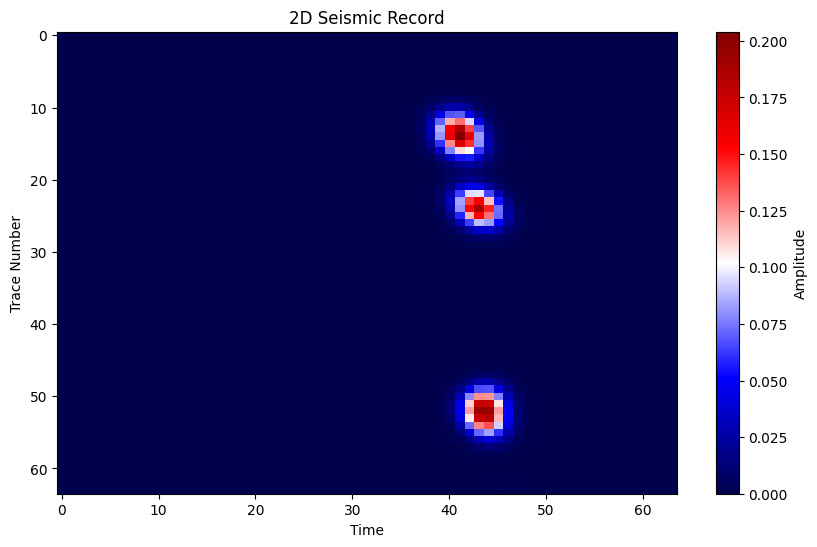

In [ ]:
#@title 查看seismic_label和channel
import numpy as np
import matplotlib.pyplot as plt
# 绘制二维地震记录
plt.figure(figsize=(10, 6))
plt.imshow(model.channel[30], aspect='auto', cmap='seismic')
plt.colorbar(label='Amplitude')
plt.xlabel('Time')
plt.ylabel('Trace Number')
plt.title('2D Seismic Record')
plt.show()

In [ ]:
model.channel.dtype

dtype('float32')

In [ ]:
#@title 检查是不是生成了n_models个不同的模型
data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'  # Base directory containing your data
"""Load data for a single index"""
fsx_0= f'{data_dir}/64_seismic_meandering_{0}.dat'
fvp_0= f'{data_dir}/64_vp_meandering_{0}.dat'
fsx_1= f'{data_dir}/64_seismic_meandering_{1}.dat'
fvp_1= f'{data_dir}/64_vp_meandering_{1}.dat'

sx_0 = np.fromfile(fsx_0, dtype=np.float32).reshape((64,64,64))
vp_0 = np.fromfile(fvp_0, dtype=np.float32).reshape((64,64,64))
sx_1 = np.fromfile(fsx_1, dtype=np.float32).reshape((64,64,64))
vp_1 = np.fromfile(fvp_1, dtype=np.float32).reshape((64,64,64))

are_close = np.allclose(sx_0, sx_1)
print(are_close)
are_close = np.allclose(vp_0, vp_1)
print(are_close)

False
False


In [ ]:
#@title time-lapse seismic - original 生成一个数据
import cigvis, vispy
import sys
# sys.path.append('/content/drive/MyDrive/SeismicWorld/syn_creation')
# from functions import *
sys.path.append('/content/drive/MyDrive/SeismicWorld')
from cigvis import colormap
from cigvis import viserplot
import viser
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'

# 选择要处理的数据索引
selected_idx = 6  # 可以根据需要更改

# 加载数据
fsx = f'{data_dir}/64_seismic_meandering_{selected_idx}.dat'
fvp = f'{data_dir}/64_vp_meandering_{selected_idx}.dat'
flx = f'{data_dir}/64_label_meandering_{selected_idx}.dat'
fcx = f'{data_dir}/64_channel_meandering_{selected_idx}.dat'
size = 64
seismic = np.fromfile(fsx, dtype=np.float32).reshape((size, size, size))
vp = np.fromfile(fvp, dtype=np.float32).reshape((size, size, size))
seis_label = np.fromfile(flx, dtype=np.uint8).reshape((size, size, size))
channel = np.fromfile(fcx, dtype=np.float32).reshape((size, size, size))
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.

# 创建模型实例
model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                resolution=[dx, dy, dz],
                mute=mute)

# 添加数据到模型
model.seis_label = seis_label
model.vp = vp
model.seismic = seismic
model.channel = channel # dtype np.uint8? np.int16?
nt = 10 # extraction amount

# 设置模拟参数
extraction_rates = [(i+1)*0.04 for i in range(0,nt)]  # 开采率序列
compaction_coefficient = 0.15  # 压实系数
poisson_ratio = 0.25  # 泊松比
young_modulus = 5e9  # 杨氏模量(Pa)
overburden_stress = 60e6  # 上覆岩层应力(Pa)
pressure_velocity_coupling = 0.15
lateral_influence_factor = 2.0  # 侧向影响因子
wavelet_type = 'ricker'  # 子波类型
f_ricker = 25  # Ricker子波频率(Hz)，确保和上面的参数一致
dt = 0.002  # 采样时间间隔(s)

# 运行时移地震模拟
timelapse_data = model.simulate_production_timelapse(
    extraction_rates=extraction_rates,
    compaction_coefficient=compaction_coefficient,
    poisson_ratio=poisson_ratio,
    young_modulus=young_modulus,
    overburden_stress=overburden_stress,
    pressure_velocity_coupling = 0.15,
    lateral_influence_factor=lateral_influence_factor,
    wavelet_type=wavelet_type,
    f_ricker=f_ricker,
    dt=dt,
    visualize_results=True  # 可视化结果
)

print(f"生成了{len(timelapse_data)}个时间步的时移地震数据")



Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating baseline seismic data...
Computing reflection coefficient: 100.00%
Generating synthetic seismic data: 100.00%
Simulating time-lapse step 1/10 with extraction rate 0.04...































































Generating time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%


TypeError: 'NoneType' object is not subscriptable

In [ ]:
#@title new insert cell: 多物理场数据构建
# 原因：
# 直接载入vp,seismic .etc没有运行add_vp,从而没有初始化self.horizon,导致后面的算法simulate_production_timelapse出现bug。
# 从头运行非时移数据，依此构建时移数据

n_models = 20 # 原本是100，这里只构建20个用于训练
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.

# data generation
for i in range(n_models):
  # 为每个模型使用不同的种子
  current_seed = seed_val + i
  # Initialize the geomodel.构建地质体部分代码不要改动，SeismicWorld的神经网络已经训练
  model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                  resolution=[dx, dy, dz],
                  mute=mute)

  # Assign Vp.
  model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
              fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
              vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
              vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
              vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
              smooth=False,  # Whether to smooth the Vp model, we will do it later.
              seed=current_seed,  # Random seed.
              mute=mute)

  # Create RGT model.
  model.add_rgt(mute=mute)

  # 没有创建rgt
  # Add inclination to the geomodel.
  model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                    b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                    seed=current_seed,
                    mute=mute)

  # Add folds to the geomodel.
  model.add_fold(N=10,  # Number of folds.
                sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                seed=current_seed,
                mute=mute)

  # Add channels.
  model.add_meandering_channel(N=1,
                              X_pos_range=[0.2, 0.3],  # Range of channel centerline's X-coordinate which the model starts at.
                              Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                              Z_pos_range=[0.2, 0.8],  # Channel Z-coordinate range (fraction of geomodel's Z-range).
                              strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                              W_range=[200, 250],  # Channel width range used for centerline simulation (m).
                              D_range=[15, 20],  # Channel depth range used for centerline simulation (m).
                              kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                              Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                              n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                              kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                              aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                              t_incision=None,  # Vertical incision time period.
                              t_aggradation=None,  # Vertical aggradation time period.
                              Wx_range=[300, 300],  # Channel width used to define channel geometry (m).
                              Dx_range=[15, 15],  # Channel depth used to define channel geometry (m).
                              epsilon_range = [0.5, 0.5],  # Vp contrast between channel fill and its upper layer.
                              incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                              seed=current_seed,
                              instance_label=False,  # Whether to make instance label.
                              mute=mute)

  model.add_density_model(method='gardner',
                        params={'a': 0.31, 'b': 0.25}, # Default Gardner params
                        channel_density_contrast=(-0.15, 0.05), # Slight variation for channels
                        mute=mute)

  # Add magnetic susceptibility model
  # Example: Layer-based susceptibility, could be overridden by facies if facies_kappa is set
  k_list_example = [
                (1e-4, 5e-4),   # 浅层：0.0001 ~ 0.0005
                (5e-4, 1e-3),   # 中层：0.0005 ~ 0.001
                (1e-3, 5e-3)    # 深层：0.001 ~ 0.005
            ]
  # fm_list_example = [0.3, 0.65] # Corresponding to the resampled Z extent implicitly
  #                              # Or, more robustly, recalculate based on resampled model.horizon if available
  #                              # For simplicity, using predefined fractions based on resampled Z.
  # This will ensure it aligns with the resampled Vp layers
  z_total = model.Zmax - model.Zmin  # Total Z range
  z_resampled = 1480 - 200  # Resampled Z range
  fm_list_example = [
      (model.horizon[0].z - 200) / z_resampled,
      (model.horizon[1].z - 200) / z_resampled
  ]

  facies_k_example = None
  if model.facies is not None: # Example if facies exist
    facies_k_example = {
        1: (5e-4, 2e-3),    # Channel fill
        2: (2e-4, 1e-3),    # Point bar
        3: (1e-4, 5e-4),    # Levee
        4: (0, 1e-4)        # Oxbow
    }


  model.add_magnetic_susceptibility(
      kappa_list=k_list_example,
      fm_list=fm_list_example, # Ensure these align with your resampled Vp layers
      kappa_disturb=1e-4,  # 或 5e-5,
      facies_kappa=facies_k_example, # Will use this if model.facies exists and facies_k_example is not None
      background_kappa=(1e-4, 5e-4),
      smooth=True,
      sigma=1.5,
      seed=current_seed,
      mute=mute
  )

  # Compute gravity anomaly (requires density model)
  model.compute_gravity(height=100.0, # Observation height in meters
                        padding_factor=2,
                        mute=mute)

  # Compute magnetic anomaly (requires magnetic susceptibility model)
  # Define Earth's field parameters for your location and observation height
  obs_height_mag = 10.0 # meters above model top
  field_inclination = 60.0 # degrees
  field_declination = 5.0  # degrees
  field_intensity = 50000.0 # nT

  from numpy.fft import fft2, ifft2, fftfreq, fftshift
  model.compute_magnetic_anomaly_3d(height=obs_height_mag,
                                  inclination=field_inclination,
                                  declination=field_declination,
                                  intensity=field_intensity,
                                  padding_factor=2,
                                  use_gpu=False,
                                  mute=mute)
  # Smooth Vp and channel model.
  model.smooth(param=['vp', 'channel'], sigma=1.5)

  # Resample the geomodel.
  model.resample_z(param='all',
                  z_range=(200, 1480),  # Crop models between z_range.
                  mute=mute)



  # Compute P-wave impedance.
  model.compute_Ip(rho=2.4)

  # Seismic.
  model.compute_rc(mute=mute)
  model.make_synseis(f_ricker=25,
                    mark_channel=True)
  nt = 10 # extraction amount
  # 设置模拟参数
  extraction_rates = [(i+1)*0.04 for i in range(0,nt)]  # 开采率序列
  compaction_coefficient = 0.15  # 压实系数
  poisson_ratio = 0.25  # 泊松比
  young_modulus = 5e9  # 杨氏模量(Pa)
  overburden_stress = 60e6  # 上覆岩层应力(Pa)
  pressure_velocity_coupling = 0.15
  lateral_influence_factor = 2.0  # 侧向影响因子
  wavelet_type = 'ricker'  # 子波类型
  f_ricker = 25  # Ricker子波频率(Hz)，确保和上面的参数一致
  dt = 0.002  # 采样时间间隔(s)

  # 运行时移地震模拟
  timelapse_data = model.simulate_production_timelapse(
      extraction_rates=extraction_rates,
      compaction_coefficient=compaction_coefficient,
      poisson_ratio=poisson_ratio,
      young_modulus=young_modulus,
      overburden_stress=overburden_stress,
      pressure_velocity_coupling = 0.15,
      lateral_influence_factor=lateral_influence_factor,
      wavelet_type=wavelet_type,
      f_ricker=f_ricker,
      dt=dt,
      visualize_results=True  # 可视化结果
  )

  print(f"生成了{len(timelapse_data)}个时间步的时移地震数据")



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 保存多物理场
selected_idx = 0
# # 将seismic数据转换为numpy数组并保存
# seismic_data = np.array([data['seismic'] for data in timelapse_data])
# seismic_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_tldMul_seis_meandering_{selected_idx}.bin")

# # 将gravity_anomaly数据转换为numpy数组并保存
# gravity_anomaly_data = np.array([data['gravity_anomaly'] for data in timelapse_data])
# gravity_anomaly_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_tldMul_gramaly_meandering_{selected_idx}.bin")

# 将magnetic_anomaly数据转换为numpy数组保存
magnetic_anomaly_data = np.array([data['magnetic_anomaly'] for data in timelapse_data])
magnetic_anomaly_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_tldMul_magmaly3D_meandering_{selected_idx}.bin")

In [ ]:
#@title 检查数据的数值异常
import torch
seismic_data = np.array([data['seismic'] for data in timelapse_data])
# First, check how many NaN values exist
nan_count = torch.isnan(torch.from_numpy(seismic_data)).sum().item()
print(f"Number of NaN values: {nan_count}")

# Replace NaN values with zeros
seismic_data = torch.nan_to_num(torch.from_numpy(seismic_data), nan=0.0)

# Verify fix worked
print(f"After fix - Min: {seismic_data.min().item()}, Max: {seismic_data.max().item()}")
print(f"NaN values remaining: {torch.isnan(seismic_data).sum().item()}")
print(seismic_data.min())

Number of NaN values: 0
After fix - Min: -0.12355096638202667, Max: 0.19527585804462433
NaN values remaining: 0
tensor(-0.1236)


In [ ]:
seismic_data = np.array([data['x_displacement'] for data in timelapse_data])
seismic_data.dtype


dtype('float64')

In [ ]:
# 将seismic数据转换为numpy数组并保存
seismic_data = np.array([data['seismic'] for data in timelapse_data])
seismic_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_tldMul_seis_meandering_{selected_idx}.bin")

# 将channel数据转换为numpy数组并保存
channel_data = np.array([data['channel'] for data in timelapse_data])
channel_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/64_tldMul_channel_meandering_{selected_idx}.bin")

In [ ]:
# 使用pickle保存timelapse_data的所有键值对
selected_idx = 1  # 可以根据需要更改

# 将seismic数据转换为numpy数组并保存
seismic_data = np.array([data['seismic'] for data in timelapse_data],dtype=np.float32)
seismic_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed/tld_seis_meandering_{selected_idx}.bin")

# 将channel数据转换为numpy数组并保存
channel_data = np.array([data['channel'] for data in timelapse_data],dtype=np.float32)
channel_data.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed/tld_channel_meandering_{selected_idx}.bin")




In [ ]:
# 之后读取时
nt = 10
loaded_seismic_data = np.fromfile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed/tld_seis_meandering_{selected_idx}.bin",
                                  dtype=np.float32).reshape(nt+1,256,256,256)
loaded_channel_data = np.fromfile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed/tld_channel_meandering_{selected_idx}.bin",
                                  dtype=np.float32).reshape(nt+1,256,256,256)


In [ ]:
#@title time-lapse seismic loop
import cigvis, vispy
import sys
from tqdm import tqdm
import os
sys.path.append('/content/drive/MyDrive/SeismicWorld/syn_creation')
from functions import *
sys.path.append('/content/drive/MyDrive/SeismicWorld')
from cigvis import colormap
from cigvis import viserplot
import viser
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'
output_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 定义要处理的索引范围
start_idx = 0
end_idx = 99  # 根据实际数据集大小调整

def process_single_index(selected_idx):
    # 构建文件路径
    fsx = f'{data_dir}/64_seismic_meandering_{selected_idx}.dat'
    fvp = f'{data_dir}/64_vp_meandering_{selected_idx}.dat'
    flx = f'{data_dir}/64_label_meandering_{selected_idx}.dat'
    fcx = f'{data_dir}/64_channel_meandering_{selected_idx}.dat'

    # 检查所需文件是否都存在
    if not all(os.path.exists(f) for f in [fsx, fvp, flx, fcx]):
        raise FileNotFoundError(f"索引 {selected_idx} 的某些必需文件不存在")

    size = 64
    seismic = np.fromfile(fsx, dtype=np.float32).reshape((size, size, size))
    vp = np.fromfile(fvp, dtype=np.float32).reshape((size, size, size))
    seis_label = np.fromfile(flx, dtype=np.uint8).reshape((size, size, size))
    channel = np.fromfile(fcx, dtype=np.float32).reshape((size, size, size))

    # 模型参数设置
    xmin, xmax, dx = 0, 6400, 100
    ymin, ymax, dy = 0, 6400, 100
    zmin, zmax, dz = 0, 1500, 20
    seed_val = 42
    mute = True  # 设为True减少输出信息

    # 创建模型实例
    model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                    resolution=[dx, dy, dz],
                    mute=mute)

    # 添加数据到模型
    model.seis_label = seis_label
    model.vp = vp
    model.seismic = seismic
    model.channel = channel

    # 模拟参数
    nt = 10
    extraction_rates = [(i+1)*0.04 for i in range(0,nt)]

    # 运行时移地震模拟
    timelapse_data = model.simulate_production_timelapse(
        extraction_rates=extraction_rates,
        compaction_coefficient=0.15,
        poisson_ratio=0.25,
        young_modulus=5e9,
        overburden_stress=60e6,
        pressure_velocity_coupling=0.15,
        lateral_influence_factor=2.0,
        wavelet_type='ricker',
        f_ricker=25,
        dt=0.002,
        visualize_results=False  # 关闭可视化以加快处理速度
    )

    # 保存结果
    seismic_data = np.array([data['seismic'] for data in timelapse_data])
    channel_data = np.array([data['channel'] for data in timelapse_data])

    seismic_output = f"{output_dir}/64_tld_seis_meandering_{selected_idx}.bin"
    channel_output = f"{output_dir}/64_tld_channel_meandering_{selected_idx}.bin"

    seismic_data.tofile(seismic_output)
    channel_data.tofile(channel_output)

    return len(timelapse_data)

# 主循环
successful = 0
failed = 0
failed_indices = []

for idx in tqdm(range(start_idx, end_idx + 1), desc="处理进度"):
    try:
        n_steps = process_single_index(idx)
        print(f"索引 {idx} 处理完成: 生成了 {n_steps} 个时间步的数据")
        successful += 1
    except Exception as e:
        print(f"处理索引 {idx} 时出错: {str(e)}")
        failed += 1
        failed_indices.append(idx)
        continue

# 打印总结报告
print("\n处理完成!")
print(f"成功处理: {successful} 个文件")
print(f"处理失败: {failed} 个文件")
if failed_indices:
    print(f"失败的索引: {failed_indices}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 多物理场油气开采时移 loop
import cigvis, vispy
import sys
from tqdm import tqdm
import os
sys.path.append('/content/drive/MyDrive/SeismicWorld/MoE')
from functions import *
sys.path.append('/content/drive/MyDrive/SeismicWorld')
from cigvis import colormap
from cigvis import viserplot
import viser
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'
output_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

def process_whole_index(n_models):
    xmin, xmax, dx = 0, 6400, 100
    ymin, ymax, dy = 0, 6400, 100
    zmin, zmax, dz = 0, 1500, 20
    seed_val = 42
    mute = False
    output_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64'
    os.makedirs(output_dir, exist_ok=True)

    successful = 0
    failed = 0
    failed_indices = []

    for i in tqdm(range(n_models), desc="处理进度"):
        try:
            current_seed = seed_val + i
            # Initialize the geomodel.构建地质体部分代码不要改动，SeismicWorld的神经网络已经训练
            model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                            resolution=[dx, dy, dz],
                            mute=mute)

            # Assign Vp.
            model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
                        fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
                        vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
                        vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
                        vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
                        smooth=False,  # Whether to smooth the Vp model, we will do it later.
                        seed=current_seed,  # Random seed.
                        mute=mute)

            # Create RGT model.
            model.add_rgt(mute=mute)

            # 没有创建rgt
            # Add inclination to the geomodel.
            model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                              b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                              seed=current_seed,
                              mute=mute)

            # Add folds to the geomodel.
            model.add_fold(N=10,  # Number of folds.
                          sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                          A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                          d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                          seed=current_seed,
                          mute=mute)

            # Add channels.
            model.add_meandering_channel(N=1,
                                        X_pos_range=[0.2, 0.3],  # Range of channel centerline's X-coordinate which the model starts at.
                                        Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                                        Z_pos_range=[0.2, 0.8],  # Channel Z-coordinate range (fraction of geomodel's Z-range).
                                        strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                                        W_range=[200, 250],  # Channel width range used for centerline simulation (m).
                                        D_range=[15, 20],  # Channel depth range used for centerline simulation (m).
                                        kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                                        Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                                        n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                                        kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                                        aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                                        t_incision=None,  # Vertical incision time period.
                                        t_aggradation=None,  # Vertical aggradation time period.
                                        Wx_range=[300, 300],  # Channel width used to define channel geometry (m).
                                        Dx_range=[15, 15],  # Channel depth used to define channel geometry (m).
                                        epsilon_range = [0.5, 0.5],  # Vp contrast between channel fill and its upper layer.
                                        incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                                        seed=current_seed,
                                        instance_label=False,  # Whether to make instance label.
                                        mute=mute)

            model.add_density_model(method='gardner',
                                  params={'a': 0.31, 'b': 0.25}, # Default Gardner params
                                  channel_density_contrast=(-0.15, 0.05), # Slight variation for channels
                                  mute=mute)

            # Add magnetic susceptibility model
            # Example: Layer-based susceptibility, could be overridden by facies if facies_kappa is set
            k_list_example = [
                          (1e-4, 5e-4),   # 浅层：0.0001 ~ 0.0005
                          (5e-4, 1e-3),   # 中层：0.0005 ~ 0.001
                          (1e-3, 5e-3)    # 深层：0.001 ~ 0.005
                      ]
            # fm_list_example = [0.3, 0.65] # Corresponding to the resampled Z extent implicitly
            #                              # Or, more robustly, recalculate based on resampled model.horizon if available
            #                              # For simplicity, using predefined fractions based on resampled Z.
            # This will ensure it aligns with the resampled Vp layers
            z_total = model.Zmax - model.Zmin  # Total Z range
            z_resampled = 1480 - 200  # Resampled Z range
            fm_list_example = [
                (model.horizon[0].z - 200) / z_resampled,
                (model.horizon[1].z - 200) / z_resampled
            ]

            facies_k_example = None
            if model.facies is not None: # Example if facies exist
              facies_k_example = {
                  1: (5e-4, 2e-3),    # Channel fill
                  2: (2e-4, 1e-3),    # Point bar
                  3: (1e-4, 5e-4),    # Levee
                  4: (0, 1e-4)        # Oxbow
              }


            model.add_magnetic_susceptibility(
                kappa_list=k_list_example,
                fm_list=fm_list_example, # Ensure these align with your resampled Vp layers
                kappa_disturb=1e-4,  # 或 5e-5,
                facies_kappa=facies_k_example, # Will use this if model.facies exists and facies_k_example is not None
                background_kappa=(1e-4, 5e-4),
                smooth=True,
                sigma=1.5,
                seed=current_seed,
                mute=mute
            )

            # Compute gravity anomaly (requires density model)
            model.compute_gravity(height=100.0, # Observation height in meters
                                  padding_factor=2,
                                  mute=mute)

            # Compute magnetic anomaly (requires magnetic susceptibility model)
            # Define Earth's field parameters for your location and observation height
            obs_height_mag = 10.0 # meters above model top
            field_inclination = 60.0 # degrees
            field_declination = 5.0  # degrees
            field_intensity = 50000.0 # nT

            from numpy.fft import fft2, ifft2, fftfreq, fftshift
            model.compute_magnetic_anomaly_3d(height=obs_height_mag,
                                            inclination=field_inclination,
                                            declination=field_declination,
                                            intensity=field_intensity,
                                            padding_factor=2,
                                            use_gpu=False,
                                            mute=mute)
            # Smooth Vp and channel model.
            model.smooth(param=['vp', 'channel'], sigma=1.5)

            # Resample the geomodel.
            model.resample_z(param='all',
                            z_range=(200, 1480),  # Crop models between z_range.
                            mute=mute)



            # Compute P-wave impedance.
            model.compute_Ip(rho=2.4)

            # Seismic.
            model.compute_rc(mute=mute)
            model.make_synseis(f_ricker=25,
                              mark_channel=True)
            nt = 10 # extraction amount
            # 设置模拟参数
            extraction_rates = [(i+1)*0.04 for i in range(0,nt)]  # 开采率序列
            compaction_coefficient = 0.15  # 压实系数
            poisson_ratio = 0.25  # 泊松比
            young_modulus = 5e9  # 杨氏模量(Pa)
            overburden_stress = 60e6  # 上覆岩层应力(Pa)
            pressure_velocity_coupling = 0.15
            lateral_influence_factor = 2.0  # 侧向影响因子
            wavelet_type = 'ricker'  # 子波类型
            f_ricker = 25  # Ricker子波频率(Hz)，确保和上面的参数一致
            dt = 0.002  # 采样时间间隔(s)

            # 运行时移地震模拟
            timelapse_data = model.simulate_production_timelapse(
                extraction_rates=extraction_rates,
                compaction_coefficient=compaction_coefficient,
                poisson_ratio=poisson_ratio,
                young_modulus=young_modulus,
                overburden_stress=overburden_stress,
                pressure_velocity_coupling = 0.15,
                lateral_influence_factor=lateral_influence_factor,
                wavelet_type=wavelet_type,
                f_ricker=f_ricker,
                dt=dt,
                visualize_results=False  # 可视化结果
            )

            seismic_data = np.array([data['seismic'] for data in timelapse_data])
            gravity_anomaly_data = np.array([data['gravity_anomaly'] for data in timelapse_data])
            magnetic_anomaly_data = np.array([data['magnetic_anomaly'] for data in timelapse_data])
            vp_data = np.array([data['vp'] for data in timelapse_data])

            seismic_output = f"{output_dir}/64_tldMul_seis_meandering_{i}.bin"
            gravity_output = f"{output_dir}/64_tldMul_gramaly_meandering_{i}.bin"
            magnetic_output = f"{output_dir}/64_tldMul_magmaly3D_meandering_{i}.bin"
            vp_output = f"{output_dir}/64_tldMul_vp_meandering_{i}.bin"

            # seismic_data.tofile(seismic_output)
            # gravity_anomaly_data.tofile(gravity_output)
            magnetic_anomaly_data.tofile(magnetic_output)
            # vp_data.tofile(vp_output)


            print(f"索引 {i} 处理完成: 生成了 {len(timelapse_data)} 个时间步的数据")
            successful += 1
        except Exception as e:
            print(f"处理索引 {i} 时出错: {str(e)}")
            failed += 1
            failed_indices.append(i)
            continue

    print("\n处理完成!")
    print(f"成功处理: {successful} 个文件")
    print(f"处理失败: {failed} 个文件")
    if failed_indices:
        print(f"失败的索引: {failed_indices}")

# 调用方法
process_whole_index(n_models=20)  # 例如生成20个模型

处理进度:   0%|          | 0/20 [00:00<?, ?it/s]

Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.03 | -0.03 | 2845.71 | 3502.68 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  4092.33  |   160.07  |   728.01  |     36.70     |
|   2    |  4713.42  |  4330.88  |   925.50  |     32.61     |
|   3    |  2700.30  |   190.70  |   709.96  |     45.16     |
|   4    |   169.83  |  1272.56  |   847.96  |     46.35     |
|   5    |  1410.82  |  3771.30  |   899.02  |     30.19     |
|   6    |

处理进度:   5%|▌         | 1/20 [01:06<20:55, 66.07s/it]

索引 0 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.04 | 3419.71 | 3574.98 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   246.73  |  4455.84  |   686.06  |     43.88     |
|   2    |  4298.54  |  5074.89  |   785.02  |     44.95     |
|   3    |   122.61  |  2767.29  |   759.16  |     55.57     |
|   4    |  3500.70  |  4834.03  |   778.90  |     35.29     |
|   5    |  5445.60  |  5249.41  |   760.27  |     3

处理进度:  10%|█         | 2/20 [02:28<22:46, 75.93s/it]

索引 1 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.02 | -0.02 | 2930.65 | 2847.60 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  2614.63  |  3468.62  |   915.85  |     35.30     |
|   2    |  1441.02  |   186.22  |   677.33  |     30.26     |
|   3    |  1002.82  |  3287.76  |   956.64  |     50.81     |
|   4    |  4424.38  |  2087.17  |   663.54  |     55.25     |
|   5    |  3950.21  |   716.86  |   662.42  | 

处理进度:  15%|█▌        | 3/20 [03:51<22:25, 79.16s/it]

索引 2 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.02 | 2993.58 | 2652.59 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1740.00  |  3123.38  |   666.20  |     40.16     |
|   2    |   462.94  |   70.63   |   730.83  |     33.53     |
|   3    |  1990.64  |  4758.21  |   651.44  |     48.75     |
|   4    |   864.07  |  5088.46  |   875.83  |     36.33     |
|   5    |  5427.69  |  4590.73  |   663.98  |     42.24 

处理进度:  20%|██        | 4/20 [04:56<19:31, 73.22s/it]

索引 3 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+-------+---------+---------+
|  a   |   b   |  Xc(m)  |  Yc(m)  |
+------+-------+---------+---------+
| 0.04 | -0.01 | 3372.19 | 2754.52 |
+------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  5684.92  |  2559.96  |   828.36  |     55.79     |
|   2    |  1462.65  |  3300.59  |   826.79  |     58.42     |
|   3    |   205.96  |   441.24  |   742.43  |     54.75     |
|   4    |  5396.16  |   866.50  |   934.25  |     45.83     |
|   5    |  6194.54  |  5980.92  |   669.73  |     5

处理进度:  25%|██▌       | 5/20 [05:58<17:20, 69.35s/it]

索引 4 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.03 | 2889.51 | 3054.79 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  2251.82  |  2753.19  |   785.17  |     40.30     |
|   2    |  1688.36  |  6179.67  |   794.10  |     46.40     |
|   3    |  5871.38  |  5751.93  |   821.62  |     36.90     |
|   4    |  3348.93  |  2298.13  |   946.48  |     31.00     |
|   5    |  2394.67  |  4400.65  |   832.31  |     46.73 

处理进度:  30%|███       | 6/20 [07:09<16:18, 69.89s/it]

索引 5 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.03 | 0.03 | 3575.25 | 3206.80 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3508.21  |   844.11  |   867.69  |     39.07     |
|   2    |  6182.96  |  5591.09  |   674.41  |     49.48     |
|   3    |  1395.52  |  3274.24  |   912.10  |     34.65     |
|   4    |  1389.47  |   469.24  |   660.32  |     44.97     |
|   5    |  1043.42  |   824.56  |   863.41  |     3

处理进度:  35%|███▌      | 7/20 [07:59<13:43, 63.31s/it]

索引 6 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.01 | 0.04 | 3522.70 | 3214.44 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   428.06  |  2644.75  |   675.36  |     52.56     |
|   2    |  3272.22  |   317.91  |   654.34  |     52.08     |
|   3    |   987.84  |  4695.97  |   841.74  |     45.13     |
|   4    |  5477.11  |  3856.37  |   823.47  |     42.00     |
|   5    |  1591.97  |   883.12  |   775.44  |     41.28 

处理进度:  40%|████      | 8/20 [09:45<15:23, 76.92s/it]

Generating synthetic seismic data: 100.00%
索引 7 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+-------+---------+---------+
|  a   |   b   |  Xc(m)  |  Yc(m)  |
+------+-------+---------+---------+
| 0.02 | -0.02 | 3446.46 | 3541.64 |
+------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3184.23  |  1703.51  |   843.97  |     37.27     |
|   2    |  3028.28  |  6210.15  |   667.26  |     39.52     |
|   3    |  4329.24  |   545.54  |   689.06  |     54.76     |
|   4    |  6270.23  |  2043.77  |   700.47  |     59.17     |
|   5    

处理进度:  45%|████▌     | 9/20 [10:43<13:01, 71.05s/it]

索引 8 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.02 | -0.02 | 3625.73 | 2887.47 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1558.51  |  3214.14  |   691.82  |     54.64     |
|   2    |  5928.69  |  2543.22  |   949.72  |     51.94     |
|   3    |  6378.99  |  2584.92  |   954.83  |     55.58     |
|   4    |   181.41  |  1652.49  |   792.88  |     54.44     |
|   5    |  1136.84  |  3941.38  |   757.51  | 

处理进度:  50%|█████     | 10/20 [12:38<14:06, 84.68s/it]

索引 9 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.04 | 3654.56 | 3034.91 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  6261.47  |   348.94  |   872.21  |     44.52     |
|   2    |  1172.15  |  2215.03  |   841.85  |     31.03     |
|   3    |  2477.98  |   71.06   |   662.20  |     35.11     |
|   4    |  1476.01  |  1755.92  |   889.00  |     42.48     |
|   5    |  5487.60  |  5750.39  |   926.47  |     5

处理进度:  55%|█████▌    | 11/20 [13:42<11:44, 78.26s/it]

索引 10 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.03 | 0.02 | 3759.34 | 3226.32 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3949.71  |  5696.89  |   786.08  |     51.34     |
|   2    |  5996.68  |  3331.58  |   874.83  |     51.84     |
|   3    |  5492.39  |   235.47  |   694.17  |     59.91     |
|   4    |  4779.53  |  1670.39  |   877.58  |     35.08     |
|   5    |  2305.52  |  2821.86  |   713.22  |     

处理进度:  60%|██████    | 12/20 [14:43<09:44, 73.09s/it]

索引 11 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.02 | 3178.27 | 3787.49 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  5847.32  |   879.86  |   817.94  |     44.49     |
|   2    |  2857.60  |  3695.28  |   762.27  |     57.36     |
|   3    |  5622.76  |  4631.93  |   657.92  |     59.69     |
|   4    |  3512.95  |  3825.21  |   813.48  |     45.47     |
|   5    |  5956.55  |  1748.16  |   685.57  |     

处理进度:  65%|██████▌   | 13/20 [15:29<07:33, 64.83s/it]

索引 12 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.01 | 3636.79 | 3516.34 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   578.18  |  6084.05  |   687.99  |     52.18     |
|   2    |  5383.95  |  4781.68  |   736.62  |     40.55     |
|   3    |  4619.92  |  6180.14  |   852.04  |     46.22     |
|   4    |  2482.57  |  2596.73  |   870.11  |     42.87     |
|   5    |  3418.86  |  4038.07  |   842.41  |     

处理进度:  70%|███████   | 14/20 [16:19<06:02, 60.42s/it]

索引 13 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.02 | 3542.60 | 3825.42 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  6181.88  |  3582.44  |   791.58  |     45.70     |
|   2    |  4913.02  |  6327.08  |   774.58  |     36.93     |
|   3    |  2398.00  |   433.26  |   845.83  |     59.78     |
|   4    |  1326.19  |  4857.90  |   707.49  |     57.89     |
|   5    |  3564.71  |  2461.77  |   649.71  |     

处理进度:  75%|███████▌  | 15/20 [17:16<04:56, 59.33s/it]

索引 14 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.02 | 3810.11 | 2931.52 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   272.42  |  3773.99  |   646.18  |     45.42     |
|   2    |  6250.54  |  1857.58  |   951.75  |     49.08     |
|   3    |  5657.52  |   125.89  |   875.41  |     45.50     |
|   4    |  3867.81  |  2419.07  |   952.63  |     49.66     |
|   5    |  4643.70  |  4372.72  |   814.84  |     

处理进度:  80%|████████  | 16/20 [19:25<05:20, 80.18s/it]

索引 15 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.03 | -0.03 | 2612.74 | 3135.23 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3716.85  |  1316.63  |   845.43  |     58.39     |
|   2    |   263.72  |  2876.16  |   753.10  |     38.64     |
|   3    |  5612.32  |  6187.08  |   897.25  |     42.57     |
|   4    |  5579.76  |   669.50  |   796.69  |     44.10     |
|   5    |   470.02  |  3542.60  |   760.53  |

处理进度:  85%|████████▌ | 17/20 [20:39<03:55, 78.45s/it]

索引 16 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.01 | 3474.40 | 3430.27 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1434.79  |  5968.90  |   942.64  |     30.68     |
|   2    |  5420.27  |  4571.99  |   857.57  |     30.32     |
|   3    |  5301.20  |  2420.88  |   898.10  |     46.08     |
|   4    |  4872.26  |  4663.19  |   748.45  |     50.09     |
|   5    |  6201.51  |  5713.75  |   930.40  |     33.03

处理进度:  90%|█████████ | 18/20 [22:28<02:55, 87.56s/it]

索引 17 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.02 | 0.02 | 3158.04 | 2985.63 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1969.96  |  3698.93  |   725.00  |     54.24     |
|   2    |  5739.22  |  5071.44  |   915.08  |     49.97     |
|   3    |  1186.94  |  2495.54  |   716.62  |     53.79     |
|   4    |   58.78   |  5059.51  |   693.37  |     39.18     |
|   5    |  4023.54  |  4319.45  |   803.97  |     

处理进度:  95%|█████████▌| 19/20 [23:50<01:26, 86.04s/it]

索引 18 处理完成: 生成了 11 个时间步的数据
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.02 | 0.03 | 2935.46 | 3589.09 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3164.72  |  3562.83  |   899.12  |     39.62     |
|   2    |  1867.32  |  6276.82  |   748.91  |     59.36     |
|   3    |  4019.09  |  1143.58  |   868.13  |     37.76     |
|   4    |  2609.34  |   834.98  |   658.70  |     41.03     |
|   5    |   90.16   |  2465.37  |   912.05  |     

处理进度: 100%|██████████| 20/20 [24:57<00:00, 74.89s/it]

索引 19 处理完成: 生成了 11 个时间步的数据

处理完成!
成功处理: 20 个文件
处理失败: 0 个文件


In [ ]:
#@title 多物理场CO2封存时移 loop
import cigvis, vispy
import sys
from tqdm import tqdm
import os
sys.path.append('/content/drive/MyDrive/SeismicWorld/MoE')
from functions import *
sys.path.append('/content/drive/MyDrive/SeismicWorld')
from cigvis import colormap
from cigvis import viserplot
import viser
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2'
output_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

def process_co2_storage_timelapse(n_models):
    xmin, xmax, dx = 0, 6400, 100
    ymin, ymax, dy = 0, 6400, 100
    zmin, zmax, dz = 0, 1500, 20
    seed_val = 42
    mute = False
    output_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2'
    os.makedirs(output_dir, exist_ok=True)

    successful = 0
    failed = 0
    failed_indices = []

    for i in tqdm(range(n_models), desc="CO2封存时移处理进度"):
        try:
            current_seed = seed_val + i
            # Initialize the geomodel.构建地质体部分代码不要改动，SeismicWorld的神经网络已经训练
            model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                            resolution=[dx, dy, dz],
                            mute=mute)

            # Assign Vp.
            model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
                        fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
                        vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
                        vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
                        vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
                        smooth=False,  # Whether to smooth the Vp model, we will do it later.
                        seed=current_seed,  # Random seed.
                        mute=mute)

            # Create RGT model.
            model.add_rgt(mute=mute)

            # Add inclination to the geomodel.
            model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                              b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                              seed=current_seed,
                              mute=mute)

            # Add folds to the geomodel.
            model.add_fold(N=10,  # Number of folds.
                          sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                          A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                          d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                          seed=current_seed,
                          mute=mute)

            # Add channels (作为CO2储层).
            model.add_meandering_channel(N=1,
                                        X_pos_range=[0.0, 0.1],  # Range of channel centerline's X-coordinate which the model starts at.
                                        Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                                        Z_pos_range=[0.0, 1.0],  # 稍微深一些的储层位置，适合CO2封存
                                        strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                                        W_range=[200, 300],  # 稍大的河道宽度，更好的储层
                                        D_range=[20, 30],  # 更厚的储层
                                        kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                                        Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                                        n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                                        kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                                        aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                                        t_incision=None,  # Vertical incision time period.
                                        t_aggradation=None,  # Vertical aggradation time period.
                                        Wx_range=[350, 400],  # 更大的储层宽度
                                        Dx_range=[25, 30],  # 更厚的储层深度
                                        epsilon_range = [0.3, 0.4],  # 适中的速度对比，适合CO2储层
                                        incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                                        seed=current_seed,
                                        instance_label=False,  # Whether to make instance label.
                                        mute=mute)

            # 添加密度模型
            model.add_density_model(method='gardner',
                                  params={'a': 0.31, 'b': 0.25}, # Default Gardner params
                                  channel_density_contrast=(-0.1, 0.05), # CO2储层密度对比稍小
                                  mute=mute)

            # 基于CO2封存地质特征的更合理的磁化率参数设置
            k_list_example = [
                (5e-5, 2e-4),   # 浅层：降低磁化率，考虑CO2影响
                (2e-4, 8e-4),   # 中层：中等磁化率
                (8e-4, 3e-3)    # 深层：较高磁化率，远离CO2影响区
            ]

            z_total = model.Zmax - model.Zmin  # Total Z range
            z_resampled = 1480 - 200  # Resampled Z range
            fm_list_example = [
                (model.horizon[0].z - 200) / z_resampled,
                (model.horizon[1].z - 200) / z_resampled
            ]

            # CO2封存情境下的相态磁化率参数
            facies_k_example = {
                1: (1e-5, 5e-5),    # Channel fill - CO2储存区域：显著降低的磁化率
                                    # CO2替代原始流体，降低整体磁性响应
                2: (1e-4, 8e-4),    # Point bar - 部分CO2影响区域：轻微降低的磁化率
                3: (2e-4, 1e-3),    # Levee - 盖层区域：保持相对较高磁化率
                4: (1e-5, 2e-5)     # Oxbow - 废弃河道，可能有CO2泄漏：很低磁化率
            }

            # 背景磁化率也需要考虑CO2的整体影响
            background_kappa_co2 = (2e-5, 1e-4)  # 降低背景磁化率

            model.add_magnetic_susceptibility(
                kappa_list=k_list_example,
                fm_list=fm_list_example,
                kappa_disturb=1e-4,
                facies_kappa=facies_k_example,
                background_kappa=(1e-4, 5e-4),
                smooth=True,
                sigma=1.5,
                seed=current_seed,
                mute=mute
            )

            # Compute gravity anomaly (requires density model)
            model.compute_gravity(height=100.0, # Observation height in meters
                                  padding_factor=2,
                                  mute=mute)

            # Compute magnetic anomaly (requires magnetic susceptibility model)
            obs_height_mag = 10.0 # meters above model top
            field_inclination = 60.0 # degrees
            field_declination = 5.0  # degrees
            field_intensity = 50000.0 # nT

            model.compute_magnetic_anomaly_3d(height=obs_height_mag,
                                            inclination=field_inclination,
                                            declination=field_declination,
                                            intensity=field_intensity,
                                            padding_factor=2,
                                            use_gpu=False,
                                            mute=mute)

            # Smooth Vp and channel model.
            model.smooth(param=['vp', 'channel'], sigma=1.5)

            # Resample the geomodel.
            model.resample_z(param='all',
                            z_range=(200, 1480),  # Crop models between z_range.
                            mute=mute)

            # Compute P-wave impedance.
            model.compute_Ip(rho=2.4)

            # Seismic.
            model.compute_rc(mute=mute)
            model.make_synseis(f_ricker=25,
                              mark_channel=True)

            # CO2封存时移模拟参数
            nt = 8  # CO2注入时间步数
            injection_rates = [(i+1)*0.1 for i in range(0, nt)]  # CO2注入率序列 [0.1, 0.2, ..., 0.8]

            # CO2封存特有参数
            co2_saturation_effect = 0.4  # CO2饱和度对速度的影响系数 0.12
            pressure_buildup_coefficient = 0.4  # 压力增加系数 0.08
            co2_density_contrast = -0.4  # CO2相对于地层流体的密度对比（负值，CO2密度低）-0.25
            tuning_thickness_factor = 3.5  # 调谐厚度因子（同相轴增粗） 1.3
            lateral_diffusion_range = 80  # 横向扩散范围(m)
            vertical_migration_factor = 0.4  # 垂直运移因子（CO2向上运移）
            noise_level = 0.015  # 噪声水平

            # 地震参数
            wavelet_type = 'ricker'
            f_ricker = 25  # 主频(Hz)
            dt = 0.002  # 采样间隔(s)

            # 运行CO2封存时移地震模拟
            print(f"开始CO2封存时移模拟 - 模型 {i}")
            co2_timelapse_data = model.simulate_co2_storage_timelapse(
                injection_rates=injection_rates,
                co2_saturation_effect=co2_saturation_effect,
                pressure_buildup_coefficient=pressure_buildup_coefficient,
                co2_density_contrast=co2_density_contrast,
                tuning_thickness_factor=tuning_thickness_factor,
                lateral_diffusion_range=lateral_diffusion_range,
                vertical_migration_factor=vertical_migration_factor,
                noise_level=noise_level,
                wavelet_type=wavelet_type,
                f_ricker=f_ricker,
                dt=dt,
                seed=current_seed,
                visualize_results=False  # 批量处理时不可视化
            )

            # 安全提取各种数据，处理可能缺失的字段
            seismic_data = np.array([data['seismic'] for data in co2_timelapse_data])
            vp_data = np.array([data['vp'] for data in co2_timelapse_data])
            co2_saturation_data = np.array([data['co2_saturation'] for data in co2_timelapse_data])
            pressure_change_data = np.array([data['pressure_change'] for data in co2_timelapse_data])
            tuning_effect_data = np.array([data['tuning_effect'] for data in co2_timelapse_data])

            # 安全提取重力和磁异常数据
            gravity_anomaly_data = None
            magnetic_anomaly_data = None

            try:
                gravity_list = []
                magnetic_list = []

                for data in co2_timelapse_data:
                    if 'gravity_anomaly' in data and data['gravity_anomaly'] is not None:
                        gravity_list.append(data['gravity_anomaly'])
                    else:
                        # 如果没有重力数据，使用模型的当前重力数据
                        if hasattr(model, 'gravity') and model.gravity is not None:
                            gravity_list.append(model.gravity.copy())
                            print("重力数据在4D碳封存函数外")
                        else:
                            gravity_list.append(np.zeros((model.vp.shape[0], model.vp.shape[1])))
                            print("重力数据空")

                    if 'magnetic_anomaly' in data and data['magnetic_anomaly'] is not None:
                        magnetic_list.append(data['magnetic_anomaly'])
                    else:
                        # 如果没有磁异常数据，使用模型的当前磁异常数据
                        if hasattr(model, 'magnetic_anomaly') and model.magnetic_anomaly is not None:
                            magnetic_list.append(model.magnetic_anomaly.copy())
                            print("磁异常数据在4D碳封存函数外")
                        else:
                            magnetic_list.append(np.zeros((model.vp.shape[0], model.vp.shape[1])))
                            print("磁异常数据空")

                if gravity_list:
                    gravity_anomaly_data = np.array(gravity_list)
                if magnetic_list:
                    magnetic_anomaly_data = np.array(magnetic_list)

            except Exception as e:
                print(f"警告：提取重力/磁异常数据时出错: {str(e)}")
                # 创建零数据作为占位符
                gravity_anomaly_data = np.zeros((len(co2_timelapse_data), model.vp.shape[0], model.vp.shape[1]))
                magnetic_anomaly_data = np.zeros((len(co2_timelapse_data), model.vp.shape[0], model.vp.shape[1]))

            # 定义输出文件路径
            seismic_output = f"{output_dir}/64_co2tl_seis_meandering_{i}.bin"
            gravity_output = f"{output_dir}/64_co2tl_gramaly_meandering_{i}.bin"
            magnetic_output = f"{output_dir}/64_co2tl_magmaly3D_meandering_{i}.bin"
            vp_output = f"{output_dir}/64_co2tl_vp_meandering_{i}.bin"
            co2_sat_output = f"{output_dir}/64_co2tl_saturation_meandering_{i}.bin"
            pressure_output = f"{output_dir}/64_co2tl_pressure_meandering_{i}.bin"
            tuning_output = f"{output_dir}/64_co2tl_tuning_meandering_{i}.bin"

            # 保存CO2封存特有的参数信息
            params_output = f"{output_dir}/64_co2tl_params_meandering_{i}.txt"

            # 保存数据到二进制文件
            seismic_data.tofile(seismic_output)
            vp_data.tofile(vp_output)
            co2_saturation_data.tofile(co2_sat_output)
            pressure_change_data.tofile(pressure_output)
            tuning_effect_data.tofile(tuning_output)

            # 保存重力和磁异常数据（如果存在）
            if gravity_anomaly_data is not None:
                gravity_anomaly_data.tofile(gravity_output)
            if magnetic_anomaly_data is not None:
                magnetic_anomaly_data.tofile(magnetic_output)

            # 保存参数信息
            with open(params_output, 'w') as f:
                f.write(f"CO2 Storage Time-lapse Parameters for Model {i}\n")
                f.write(f"=====================================\n")
                f.write(f"Injection rates: {injection_rates}\n")
                f.write(f"CO2 saturation effect: {co2_saturation_effect}\n")
                f.write(f"Pressure buildup coefficient: {pressure_buildup_coefficient}\n")
                f.write(f"CO2 density contrast: {co2_density_contrast}\n")
                f.write(f"Tuning thickness factor: {tuning_thickness_factor}\n")
                f.write(f"Lateral diffusion range: {lateral_diffusion_range} m\n")
                f.write(f"Vertical migration factor: {vertical_migration_factor}\n")
                f.write(f"Noise level: {noise_level}\n")
                f.write(f"Wavelet frequency: {f_ricker} Hz\n")
                f.write(f"Sampling interval: {dt} s\n")
                f.write(f"Number of time steps: {len(co2_timelapse_data)}\n")
                f.write(f"Seismic data shape: {seismic_data.shape}\n")
                f.write(f"CO2 saturation data shape: {co2_saturation_data.shape}\n")
                f.write(f"Pressure change data shape: {pressure_change_data.shape}\n")
                if gravity_anomaly_data is not None:
                    f.write(f"Gravity anomaly data shape: {gravity_anomaly_data.shape}\n")
                if magnetic_anomaly_data is not None:
                    f.write(f"Magnetic anomaly data shape: {magnetic_anomaly_data.shape}\n")
                f.write(f"Seed: {current_seed}\n")

            print(f"索引 {i} CO2封存时移处理完成: 生成了 {len(co2_timelapse_data)} 个时间步的数据")
            print(f"  - 地震数据形状: {seismic_data.shape}")
            print(f"  - CO2饱和度数据形状: {co2_saturation_data.shape}")
            print(f"  - 压力变化数据形状: {pressure_change_data.shape}")
            if gravity_anomaly_data is not None:
                print(f"  - 重力异常数据形状: {gravity_anomaly_data.shape}")
            if magnetic_anomaly_data is not None:
                print(f"  - 磁异常数据形状: {magnetic_anomaly_data.shape}")

            successful += 1

        except Exception as e:
            print(f"处理CO2封存模型索引 {i} 时出错: {str(e)}")
            import traceback
            traceback.print_exc()
            failed += 1
            failed_indices.append(i)
            continue

    print("\nCO2封存时移处理完成!")
    print(f"成功处理: {successful} 个文件")
    print(f"处理失败: {failed} 个文件")
    if failed_indices:
        print(f"失败的索引: {failed_indices}")

    return co2_timelapse_data

def visualize_co2_sample(model_index=0):
    """
    可视化单个CO2封存时移样本 - 调试版本
    """
    data_dir = '/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2'

    # 读取数据
    seismic_file = f"{data_dir}/64_co2tl_seis_meandering_{model_index}.bin"
    co2_sat_file = f"{data_dir}/64_co2tl_saturation_meandering_{model_index}.bin"
    pressure_file = f"{data_dir}/64_co2tl_pressure_meandering_{model_index}.bin"
    params_file = f"{data_dir}/64_co2tl_params_meandering_{model_index}.txt"

    if not os.path.exists(seismic_file):
        print(f"文件不存在: {seismic_file}")
        return

    # 读取参数文件获取数据形状信息
    print("=== 读取参数文件 ===")
    seismic_shape = None
    co2_shape = None
    pressure_shape = None
    time_steps = None

    if os.path.exists(params_file):
        with open(params_file, 'r') as f:
            content = f.read()
            print("参数文件内容:")
            print(content)
            print("\n" + "="*50 + "\n")

            for line in content.split('\n'):
                if 'Seismic data shape:' in line:
                    shape_str = line.split(': ')[1].strip().strip('()')
                    seismic_shape = tuple(map(int, shape_str.split(', ')))
                elif 'CO2 saturation data shape:' in line:
                    shape_str = line.split(': ')[1].strip().strip('()')
                    co2_shape = tuple(map(int, shape_str.split(', ')))
                elif 'Pressure change data shape:' in line:
                    shape_str = line.split(': ')[1].strip().strip('()')
                    pressure_shape = tuple(map(int, shape_str.split(', ')))
                elif 'Number of time steps:' in line:
                    time_steps = int(line.split(': ')[1].strip())

    print(f"从参数文件读取的形状:")
    print(f"  - Seismic shape: {seismic_shape}")
    print(f"  - CO2 saturation shape: {co2_shape}")
    print(f"  - Pressure change shape: {pressure_shape}")
    print(f"  - Time steps: {time_steps}")

    # 检查文件大小
    print("\n=== 检查文件大小 ===")
    files_to_check = [
        (seismic_file, "Seismic"),
        (co2_sat_file, "CO2 Saturation"),
        (pressure_file, "Pressure Change")
    ]

    file_sizes = {}
    for file_path, name in files_to_check:
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            file_sizes[name] = file_size
            # 假设是float32数据，每个元素4字节
            num_elements = file_size // 4
            print(f"{name}: {file_size} bytes, {num_elements} elements")
        else:
            print(f"{name}: 文件不存在")

    # 尝试推断正确的形状
    print("\n=== 推断数据形状 ===")

    # 从地震数据推断形状
    if 'Seismic' in file_sizes:
        seismic_elements = file_sizes['Seismic'] // 4
        print(f"地震数据元素数量: {seismic_elements}")

        # 尝试不同的形状组合
        possible_shapes = []

        # 假设时间步数
        for nt in [8, 9, 10]:  # 可能的时间步数
            remaining = seismic_elements // nt
            if seismic_elements % nt == 0:
                # 尝试不同的空间维度
                for nz in [64, 75, 80]:  # 可能的深度维度
                    if remaining % nz == 0:
                        spatial_2d = remaining // nz
                        # 尝试正方形
                        sqrt_val = int(np.sqrt(spatial_2d))
                        if sqrt_val * sqrt_val == spatial_2d:
                            possible_shapes.append((nt, sqrt_val, sqrt_val, nz))
                        # 尝试常见的矩形
                        for ny in [64, 65, 66, 67, 68]:
                            if spatial_2d % ny == 0:
                                nx = spatial_2d // ny
                                if 60 <= nx <= 70:  # 合理的x维度范围
                                    possible_shapes.append((nt, ny, nx, nz))

        print(f"可能的形状组合: {possible_shapes[:10]}")  # 只显示前10个

        # 选择最合理的形状
        if possible_shapes:
            # 优先选择接近正方形的形状
            best_shape = possible_shapes[0]
            for shape in possible_shapes:
                if abs(shape[1] - shape[2]) < abs(best_shape[1] - best_shape[2]):
                    best_shape = shape

            print(f"选择的形状: {best_shape}")

            # 尝试读取和可视化数据
            try:
                print(f"\n=== 尝试读取数据 ===")
                seismic_data = np.fromfile(seismic_file, dtype=np.float32).reshape(best_shape)
                print(f"成功读取地震数据，形状: {seismic_data.shape}")

                co2_sat_data = np.fromfile(co2_sat_file, dtype=np.float64).reshape(best_shape)
                print(f"成功读取CO2饱和度数据，形状: {co2_sat_data.shape}")

                pressure_data = np.fromfile(pressure_file, dtype=np.float64).reshape(best_shape)
                print(f"成功读取压力数据，形状: {pressure_data.shape}")

                # 可视化
                print(f"\n=== 开始可视化 ===")
                fig, axes = plt.subplots(3, 3, figsize=(15, 15))
                fig.suptitle(f'CO2 Storage Time-lapse - Model {model_index}', fontsize=16)

                # 选择中间剖面
                nt, ny, nx, nz = best_shape
                inline_idx = ny // 2

                # 显示几个关键时间步
                time_indices = [0, nt//3, 2*nt//3] if nt >= 3 else [0, min(1, nt-1), min(2, nt-1)]

                for i, t_idx in enumerate(time_indices):
                    if t_idx < nt:
                        # 地震数据
                        seismic_slice = seismic_data[t_idx, inline_idx, :, :]
                        vmax = np.max(np.abs(seismic_slice)) * 0.8 if np.max(np.abs(seismic_slice)) > 0 else 1
                        im0 = axes[0, i].imshow(seismic_slice.T, cmap='seismic', aspect='auto', vmin=-vmax, vmax=vmax)
                        axes[0, i].set_title(f'Seismic - Step {t_idx}')
                        axes[0, i].set_xlabel('X')
                        axes[0, i].set_ylabel('Z')
                        plt.colorbar(im0, ax=axes[0, i], shrink=0.8)

                        # CO2饱和度
                        co2_slice = co2_sat_data[t_idx, inline_idx, :, :]
                        im1 = axes[1, i].imshow(co2_slice.T, cmap='Blues', aspect='auto',
                                              vmin=0, vmax=np.max(co2_slice) if np.max(co2_slice) > 0 else 1)
                        axes[1, i].set_title(f'CO2 Saturation - Step {t_idx}')
                        axes[1, i].set_xlabel('X')
                        axes[1, i].set_ylabel('Z')
                        plt.colorbar(im1, ax=axes[1, i], shrink=0.8)

                        # 压力变化
                        pressure_slice = pressure_data[t_idx, inline_idx, :, :]
                        vmax_p = np.max(np.abs(pressure_slice)) if np.max(np.abs(pressure_slice)) > 0 else 1
                        im2 = axes[2, i].imshow(pressure_slice.T, cmap='RdBu_r', aspect='auto',
                                              vmin=-vmax_p, vmax=vmax_p)
                        axes[2, i].set_title(f'Pressure Change - Step {t_idx}')
                        axes[2, i].set_xlabel('X')
                        axes[2, i].set_ylabel('Z')
                        plt.colorbar(im2, ax=axes[2, i], shrink=0.8)

                        # 打印统计信息
                        print(f"时间步 {t_idx}:")
                        print(f"  地震数据范围: [{np.min(seismic_slice):.3f}, {np.max(seismic_slice):.3f}]")
                        print(f"  CO2饱和度范围: [{np.min(co2_slice):.3f}, {np.max(co2_slice):.3f}]")
                        print(f"  压力变化范围: [{np.min(pressure_slice):.3f}, {np.max(pressure_slice):.3f}]")

                plt.tight_layout()
                plt.show()

                print(f"\n=== 可视化完成 ===")
                print(f"成功可视化模型 {model_index}")
                print(f"最终使用的数据形状: {best_shape}")
                print(f"时间步数: {nt}")
                print(f"空间维度: {ny} x {nx} x {nz}")

            except Exception as e:
                print(f"读取或可视化数据时出错: {str(e)}")
                import traceback
                traceback.print_exc()
        else:
            print("无法推断合理的数据形状")
    else:
        print("无法获取地震数据文件大小")


# 生成CO2封存时移数据集
model = process_co2_storage_timelapse(n_models=20)  # 先测试1个模型




CO2封存时移处理进度:   0%|          | 0/20 [00:00<?, ?it/s]

Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.03 | -0.03 | 2845.71 | 3502.68 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  4092.33  |   160.07  |   728.01  |     36.70     |
|   2    |  4713.42  |  4330.88  |   925.50  |     32.61     |
|   3    |  2700.30  |   190.70  |   709.96  |     45.16     |
|   4    |   169.83  |  1272.56  |   847.96  |     46.35     |
|   5    |  1410.82  |  3771.30  |   899.02  |     30.19     |
|   6    |

CO2封存时移处理进度:   5%|▌         | 1/20 [00:53<16:50, 53.21s/it]

索引 0 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.04 | 3419.71 | 3574.98 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   246.73  |  4455.84  |   686.06  |     43.88     |
|   2    |  4298.54  |  5074.89  |   785.02  |     44.95     |
|   3    |   122.61  |  2767.29

CO2封存时移处理进度:  10%|█         | 2/20 [01:51<16:48, 56.04s/it]

索引 1 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.02 | -0.02 | 2930.65 | 2847.60 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  2614.63  |  3468.62  |   915.85  |     35.30     |
|   2    |  1441.02  |   186.22  |   677.33  |     30.26     |
|   3    |  1002.82  |  32

CO2封存时移处理进度:  15%|█▌        | 3/20 [02:59<17:29, 61.73s/it]

索引 2 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.02 | 2993.58 | 2652.59 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1740.00  |  3123.38  |   666.20  |     40.16     |
|   2    |   462.94  |   70.63   |   730.83  |     33.53     |
|   3    |  1990.64  |  4758.21  |  

CO2封存时移处理进度:  20%|██        | 4/20 [03:38<14:04, 52.77s/it]

索引 3 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+-------+---------+---------+
|  a   |   b   |  Xc(m)  |  Yc(m)  |
+------+-------+---------+---------+
| 0.04 | -0.01 | 3372.19 | 2754.52 |
+------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  5684.92  |  2559.96  |   828.36  |     55.79     |
|   2    |  1462.65  |  3300.59  |   826.79  |     58.42     |
|   3    |   205.96  |   441.24

CO2封存时移处理进度:  25%|██▌       | 5/20 [04:13<11:31, 46.13s/it]

索引 4 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.03 | 2889.51 | 3054.79 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  2251.82  |  2753.19  |   785.17  |     40.30     |
|   2    |  1688.36  |  6179.67  |   794.10  |     46.40     |
|   3    |  5871.38  |  5751.93  |  

CO2封存时移处理进度:  30%|███       | 6/20 [05:13<11:53, 50.98s/it]

索引 5 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.03 | 0.03 | 3575.25 | 3206.80 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3508.21  |   844.11  |   867.69  |     39.07     |
|   2    |  6182.96  |  5591.09  |   674.41  |     49.48     |
|   3    |  1395.52  |  3274.24

CO2封存时移处理进度:  35%|███▌      | 7/20 [06:14<11:46, 54.32s/it]

索引 6 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.01 | 0.04 | 3522.70 | 3214.44 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   428.06  |  2644.75  |   675.36  |     52.56     |
|   2    |  3272.22  |   317.91  |   654.34  |     52.08     |
|   3    |   987.84  |  4695.97  |  

CO2封存时移处理进度:  40%|████      | 8/20 [07:18<11:29, 57.42s/it]

索引 7 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+-------+---------+---------+
|  a   |   b   |  Xc(m)  |  Yc(m)  |
+------+-------+---------+---------+
| 0.02 | -0.02 | 3446.46 | 3541.64 |
+------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3184.23  |  1703.51  |   843.97  |     37.27     |
|   2    |  3028.28  |  6210.15  |   667.26  |     39.52     |
|   3    |  4329.24  |   545.54

CO2封存时移处理进度:  45%|████▌     | 9/20 [08:07<10:03, 54.85s/it]

索引 8 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.02 | -0.02 | 3625.73 | 2887.47 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1558.51  |  3214.14  |   691.82  |     54.64     |
|   2    |  5928.69  |  2543.22  |   949.72  |     51.94     |
|   3    |  6378.99  |  25

CO2封存时移处理进度:  50%|█████     | 10/20 [09:10<09:31, 57.12s/it]

索引 9 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.04 | 3654.56 | 3034.91 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  6261.47  |   348.94  |   872.21  |     44.52     |
|   2    |  1172.15  |  2215.03  |   841.85  |     31.03     |
|   3    |  2477.98  |   71.06 

CO2封存时移处理进度:  55%|█████▌    | 11/20 [10:21<09:14, 61.62s/it]

索引 10 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.03 | 0.02 | 3759.34 | 3226.32 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3949.71  |  5696.89  |   786.08  |     51.34     |
|   2    |  5996.68  |  3331.58  |   874.83  |     51.84     |
|   3    |  5492.39  |   235.4

CO2封存时移处理进度:  60%|██████    | 12/20 [11:06<07:30, 56.31s/it]

索引 11 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.02 | 3178.27 | 3787.49 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  5847.32  |   879.86  |   817.94  |     44.49     |
|   2    |  2857.60  |  3695.28  |   762.27  |     57.36     |
|   3    |  5622.76  |  4631.9

CO2封存时移处理进度:  65%|██████▌   | 13/20 [11:52<06:13, 53.31s/it]

索引 12 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.01 | 3636.79 | 3516.34 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   578.18  |  6084.05  |   687.99  |     52.18     |
|   2    |  5383.95  |  4781.68  |   736.62  |     40.55     |
|   3    |  4619.92  |  6180.1

CO2封存时移处理进度:  70%|███████   | 14/20 [12:34<04:59, 49.90s/it]

索引 13 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.04 | 0.02 | 3542.60 | 3825.42 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  6181.88  |  3582.44  |   791.58  |     45.70     |
|   2    |  4913.02  |  6327.08  |   774.58  |     36.93     |
|   3    |  2398.00  |   433.2

CO2封存时移处理进度:  75%|███████▌  | 15/20 [13:05<03:41, 44.25s/it]

索引 14 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.01 | 0.02 | 3810.11 | 2931.52 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |   272.42  |  3773.99  |   646.18  |     45.42     |
|   2    |  6250.54  |  1857.58  |   951.75  |     49.08     |
|   3    |  5657.52  |   125.8

CO2封存时移处理进度:  80%|████████  | 16/20 [14:38<03:55, 58.93s/it]

索引 15 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.03 | -0.03 | 2612.74 | 3135.23 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3716.85  |  1316.63  |   845.43  |     58.39     |
|   2    |   263.72  |  2876.16  |   753.10  |     38.64     |
|   3    |  5612.32  |  6

CO2封存时移处理进度:  85%|████████▌ | 17/20 [15:28<02:48, 56.18s/it]

索引 16 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+------+------+---------+---------+
|  a   |  b   |  Xc(m)  |  Yc(m)  |
+------+------+---------+---------+
| 0.02 | 0.01 | 3474.40 | 3430.27 |
+------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1434.79  |  5968.90  |   942.64  |     30.68     |
|   2    |  5420.27  |  4571.99  |   857.57  |     30.32     |
|   3    |  5301.20  |  2420.88  | 

CO2封存时移处理进度:  90%|█████████ | 18/20 [17:19<02:25, 72.55s/it]

索引 17 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.02 | 0.02 | 3158.04 | 2985.63 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  1969.96  |  3698.93  |   725.00  |     54.24     |
|   2    |  5739.22  |  5071.44  |   915.08  |     49.97     |
|   3    |  1186.94  |  2495.5

CO2封存时移处理进度:  95%|█████████▌| 19/20 [18:04<01:04, 64.39s/it]

索引 18 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+------+---------+---------+
|   a   |  b   |  Xc(m)  |  Yc(m)  |
+-------+------+---------+---------+
| -0.02 | 0.03 | 2935.46 | 3589.09 |
+-------+------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  3164.72  |  3562.83  |   899.12  |     39.62     |
|   2    |  1867.32  |  6276.82  |   748.91  |     59.36     |
|   3    |  4019.09  |  1143.5

CO2封存时移处理进度: 100%|██████████| 20/20 [18:52<00:00, 56.63s/it]

索引 19 CO2封存时移处理完成: 生成了 9 个时间步的数据
  - 地震数据形状: (9, 64, 64, 64)
  - CO2饱和度数据形状: (9, 64, 64, 64)
  - 压力变化数据形状: (9, 64, 64, 64)
  - 重力异常数据形状: (9, 64, 64)
  - 磁异常数据形状: (9, 64, 64)

CO2封存时移处理完成!
成功处理: 20 个文件
处理失败: 0 个文件


=== 读取参数文件 ===
参数文件内容:
CO2 Storage Time-lapse Parameters for Model 0
Injection rates: [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8]
CO2 saturation effect: 0.4
Pressure buildup coefficient: 0.4
CO2 density contrast: -0.4
Tuning thickness factor: 3.5
Lateral diffusion range: 80 m
Vertical migration factor: 0.4
Noise level: 0.015
Wavelet frequency: 25 Hz
Sampling interval: 0.002 s
Number of time steps: 9
Seismic data shape: (9, 64, 64, 64)
CO2 saturation data shape: (9, 64, 64, 64)
Pressure change data shape: (9, 64, 64, 64)
Gravity anomaly data shape: (9, 64, 64)
Magnetic anomaly data shape: (9, 64, 64)
Seed: 45



从参数文件读取的形状:
  - Seismic shape: (9, 64, 64, 64)
  - CO2 saturation shape: (9, 64, 64, 64)
  - Pressure change shape: (9, 64, 64, 64)
  - Time steps: 9

=== 检查文件大小 ===
Seismic: 9437184 bytes, 2359296 elements
CO2 Saturation: 18874368 bytes, 4718592 elements
Pressure Change: 18874368 bytes, 4718592 elements

=== 推断数据形状 ===
地震数据元素数量: 235929

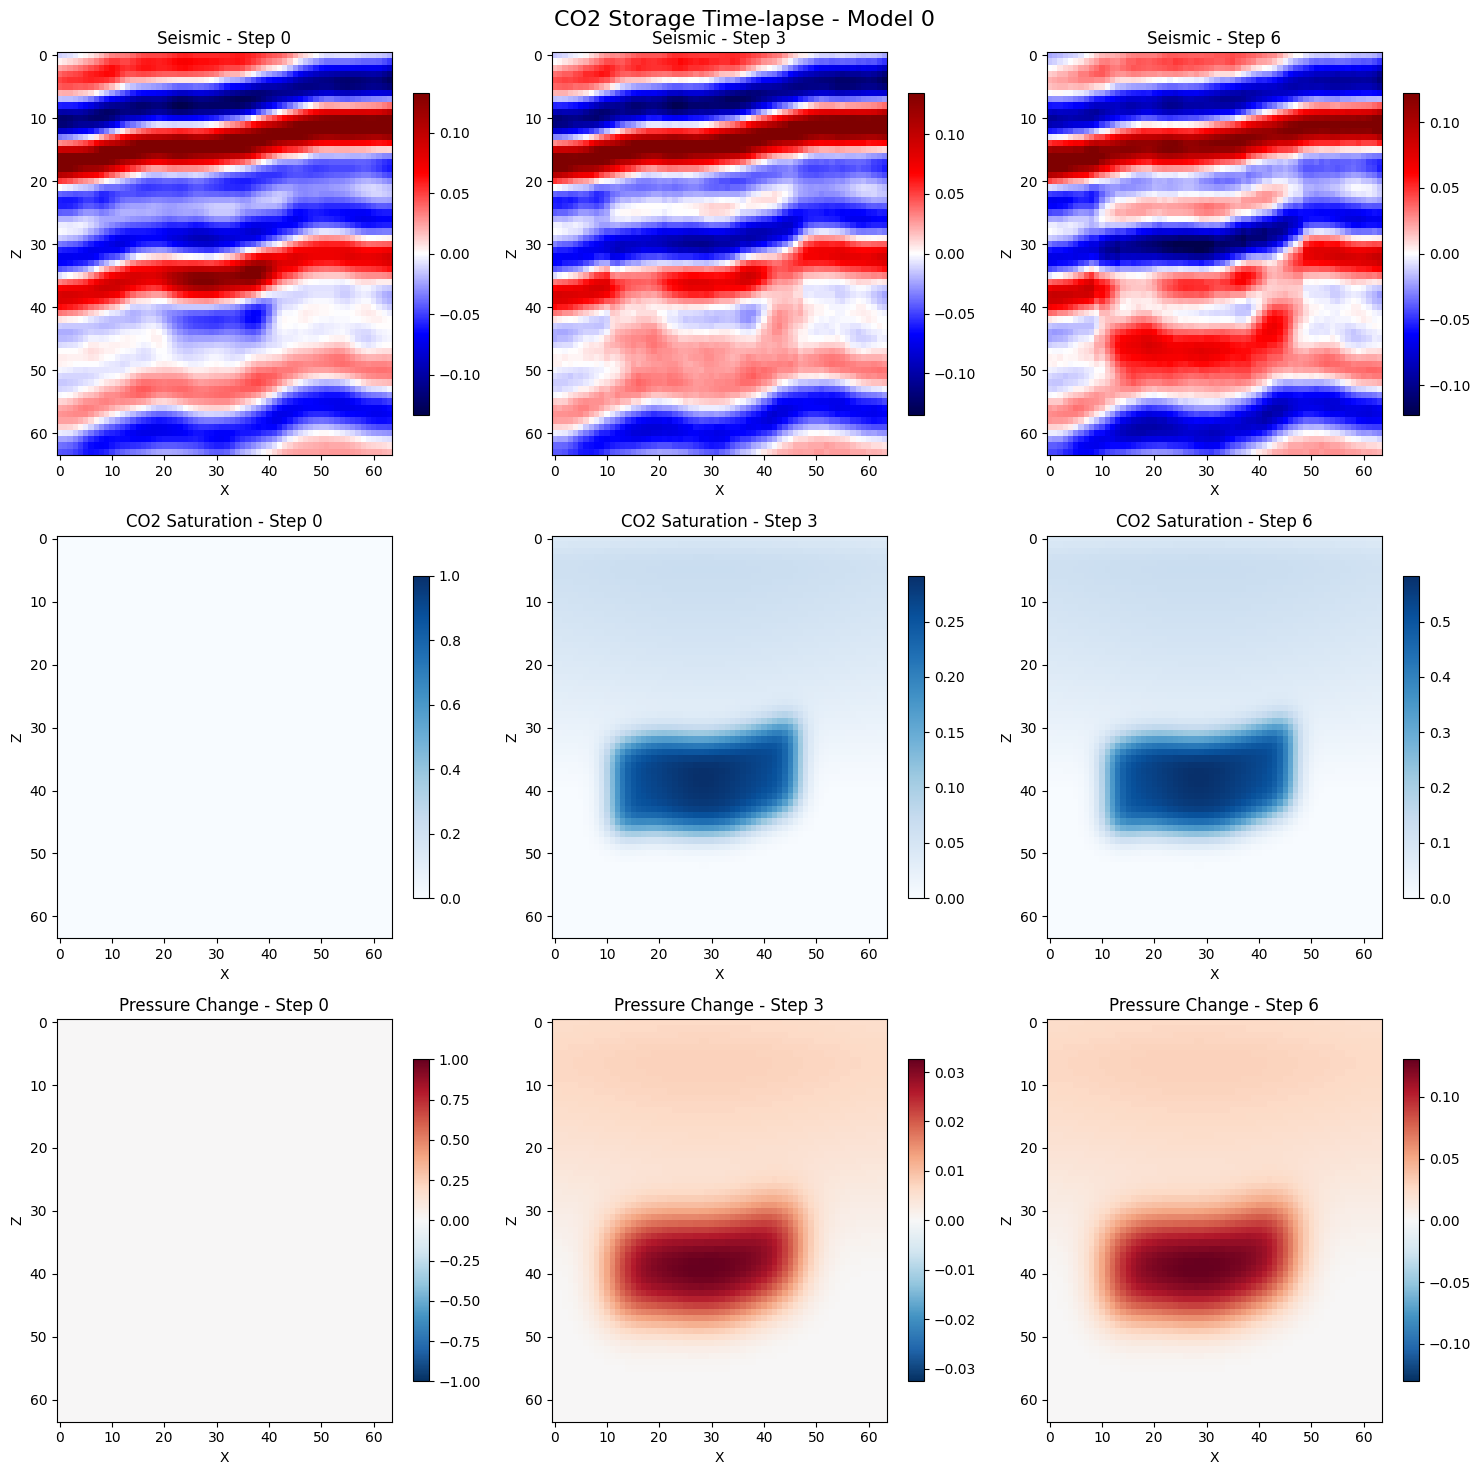


=== 可视化完成 ===
成功可视化模型 0
最终使用的数据形状: (9, 64, 64, 64)
时间步数: 9
空间维度: 64 x 64 x 64


In [ ]:
# 可视化第一个样本
visualize_co2_sample(model_index=0)